# RetinaMNIST with rotations

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly flipped by 90 degrees**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [98]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:
    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)

    def to_tensor(self):
        return torch.Tensor([self.x_min, self.y_min, self.x_max, self.y_max])


class MnistCanvas:
    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

    def plot_comparison(self, boxes: List[MnistBox]):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        ax1.set_title('Ground truth', size=14)
        ax1.imshow(self.image)
        for box in self.boxes:
            box.plot_on_ax(ax1)

        ax2.set_title('Predictions', size=14)
        ax2.imshow(self.image)
        for box in boxes:
            box.plot_on_ax(ax2)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [99]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in [1, 2, 3, 4, 5]:
            continue
        rotate = np.random.random() > 0.5
        current_digit = digits[current_digit_index]
        if rotate:
            current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=current_digit_class,
            rotated=rotate,
        ):
            attempts_done += 1
    return new_canvas

Let us have a look at example canvas (rotated digits have additional *added to description).

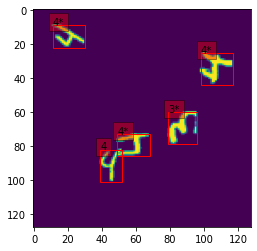

In [100]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

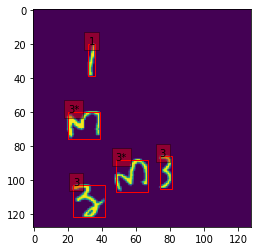

In [101]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (2pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

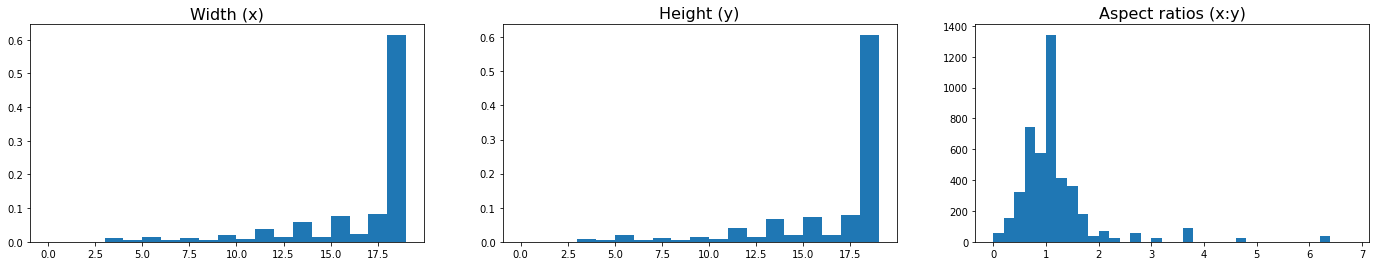

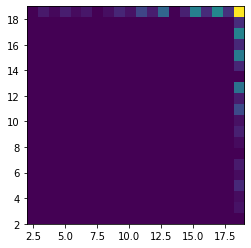

AVG_ANCHOR_SIZES: [16.63361307420495, 16.53268551236749]
SIZES_RANGES: X: [2, 19] Y: [2, 19]
Selected anchors sizes: 
[[19 15]
 [15 19]
 [19 17]
 [17 19]
 [19 19]]


In [102]:
ANALYZE_CANVAS_SIZE = 1000

ANALYZE_CANVAS = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(ANALYZE_CANVAS_SIZE)
]

x_len = []
y_len = []
for canvas in ANALYZE_CANVAS:
    for box in canvas.boxes:
        x_len.append(box.x_diff)
        y_len.append(box.y_diff)

x_len = np.asarray(x_len)
y_len = np.asarray(y_len)

AVG_ANCHOR_SIZES = [np.mean(x_len), np.mean(y_len)]
SIZES_RANGES = [[np.min(x_len), np.max(x_len)], [np.min(y_len), np.max(y_len)]]

fig, (width, height, aspect_ratios) = plt.subplots(1, 3, figsize=(24, 4))
width.set_title('Width (x)', size=16)
height.set_title('Height (y)', size=16)
aspect_ratios.set_title('Aspect ratios (x:y)', size=16)
width.hist(x_len, bins=np.arange(SIZES_RANGES[0][1]+1), density=True)
height.hist(y_len, bins=np.arange(SIZES_RANGES[1][1]+1), density=True)
aspect_ratios.hist(x_len / y_len, bins=np.arange(0, 7, 0.2))
plt.show()

heatmap, xedges, yedges = np.histogram2d(x_len, y_len, bins=SIZES_RANGES[0][1]+1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()
print("AVG_ANCHOR_SIZES:", AVG_ANCHOR_SIZES)
print("SIZES_RANGES:", "X:", SIZES_RANGES[0], "Y:", SIZES_RANGES[1])

# Select most common sizes. Perform k-argmax on 2d array.
ANCHOR_SIZES_COUNT = 5
indices = np.unravel_index(np.argsort(heatmap.ravel())[-ANCHOR_SIZES_COUNT:], heatmap.shape)
ANCHOR_SIZES = np.asarray(indices).T
print(f'Selected anchors sizes: \n{ANCHOR_SIZES}')

# More than 60% boxes have x and y size equal to 19.
# Average x, y size is ~16.5.
# There is very small number of boxes with height or width smaller than 10.
# From aspect ratio we get that most of the digit boxes are nearly square.
# However, some may be really high and narrow (e.g. digit 1).
# On a heatmap we can see that most of the boxes have aspect ratios (15:19), (16:19), ..., (19:19), (19:18), ..., (19:15)

### Model building (2pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

We provided you with a backbone model architecture that accepts a `MnistCanvas` instance and output a tensor with shape $(1, 16, 16, 128)$. It should be trained together with the rest of your solution.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 8, \left(n + \frac{1}{2}\right) * 8\right)$  for $m, n \in \{0, 1, \dots, 16 - 1\}$,

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{digitClassificationHead}$:

$\texttt{digitClassificationHead}$ should accept backbone output as an input and output `digit_classification_output` tensor of shape $(len(\texttt{anchors)}, 5)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j + 1$ (ground truth box).

#### $\texttt{rotationClassificationHead}$:

$\texttt{rotationClassificationHead}$ should accept backbone output as an input and output `rotation_classification_output` tensor of shape $(len(\texttt{anchors)}, 2)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit which was not rotated when $j = 0$ and was rotated when $j = 1$.

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

#### *Hint*: be careful with a construction of a head output as a simple reshaping might cause unexpected permutation of anchors.

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

In [103]:
from torch import nn


def visualize_anchors(x_min, y_min, x_max, y_max):
    im = MnistCanvas.get_empty_of_size((128, 128))
    fig1, ax1 = plt.subplots()
    ax1.set_title(f'{x_min}, {y_min}, {x_max}, {y_max}')
    ax1.add_patch(patches.Rectangle(
        (y_min, x_min),
        y_max - y_min,
        x_max - x_min,
        linewidth=1,
        edgecolor='b',
        facecolor='none',
    ))
    plt.imshow(im.image)


anchors = []
for m in range(16):
    for n in range(16):
        for size in ANCHOR_SIZES:
            center = torch.as_tensor([(m + 0.5) * 8, (n + 0.5) * 8])
            half_size = size * 0.5
            (x_min, y_min), (x_max, y_max) = [int(a) for a in (center - half_size)], [int(a) for a in (center + half_size)]
            x_min, y_min = max(0, x_min), max(0, y_min)
            x_max, y_max = min(127, x_max), min(127, y_max)
            # visualize_anchors(x_min, y_min, x_max, y_max)
            anchors.append(MnistBox(x_min, y_min, x_max, y_max))


class DigitDetectionModelOutput:
    def __init__(
        self,
        anchors: List[MnistBox],
        digit_classification_output: torch.Tensor,
        rotation_classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.digit_classification_output = digit_classification_output
        self.rotation_classification_output = rotation_classification_output
        self.box_regression_output = box_regression_output


class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.output_shape = (16, 16, 128)
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(16 * (2 ** i), 16 * (2 ** (i + 1)), (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
              ]) for i in range(1, 3)
            ]
        )

    def forward(self, x: MnistCanvas) -> torch.Tensor:
        image = torch.Tensor(x.image).to(DEVICE).view(1, 1, 128, 128)
        aux = self.first_block(image)
        for block in self.blocks:
            aux = block(aux)
        return aux


class Head(nn.Module):
    def __init__(self, features_per_anchor):
        super().__init__()
        self.features_per_grid = ANCHOR_SIZES_COUNT * features_per_anchor
        self.output_shape = (len(anchors), features_per_anchor)

        self.block = torch.nn.Sequential(
            nn.Conv2d(128, 128, (5, 5), padding=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(128, self.features_per_grid, (3, 3), padding=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.size() == (1, 128, 16, 16)

        x = self.block(x)

        x = x.view(self.features_per_grid, 16, 16)\
            .permute(1, 2, 0)\
            .reshape(self.output_shape[0], self.output_shape[1])

        assert x.size() == self.output_shape
        return x


class DigitClassificationHead(Head):
    def __init__(self):
        super().__init__(features_per_anchor=5)


class RotationClassificationHead(Head):
    def __init__(self):
        super().__init__(features_per_anchor=2)


class BoxRegressionHead(Head):
    def __init__(self):
        super().__init__(features_per_anchor=4)


class DigitDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Backbone().to(DEVICE)
        self.anchors = anchors
        self.digit_classification = DigitClassificationHead().to(DEVICE)
        self.rotation_classification = RotationClassificationHead().to(DEVICE)
        self.box_regression = BoxRegressionHead().to(DEVICE)


    def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
        x = self.backbone(x)
        return DigitDetectionModelOutput(
            anchors=self.anchors,
            digit_classification_output=self.digit_classification(x),
            rotation_classification_output=self.rotation_classification(x),
            box_regression_output=self.box_regression(x)
        )

### Significant overlap (4pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `digit_classification_target` - a tensor of shape $(len(anchors), 5)$,
- `rotation_classification_target` - a tensor of shape $(len(anchors), 2)$
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

`digit_classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{digit_classification_target}[i, \texttt{gt_best.class_nb} - 1] = 1.$$

`rotation_classification_target` should encode if matched `gt_best` has a digit which was rotated, namely:

$$\texttt{rotation_classification_target}[i, 0] = 1,$$

if `gt_best` digit was not rotated and:

$$\texttt{rotation_classification_target}[i, 1] = 1,$$

if `gt_best` digit was rotated (this might be interpreted as a one-hot encoding if a digit was rotated).

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [104]:
from torchvision.ops import nms


class DigitDetectionModelTarget:
    def __init__(
        self,
        digit_classification_target: torch.Tensor,
        rotation_classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.digit_classification_target = digit_classification_target
        self.rotation_classification_target = rotation_classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors


class TargetDecoder:
    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.2,
        nb_of_classes: int=5,
    ) -> DigitDetectionModelTarget:
        digit_classification_target = torch.zeros(len(anchors), nb_of_classes).to(DEVICE)
        rotation_classification_target = torch.zeros(len(anchors), 2).to(DEVICE)
        box_regression_target = torch.zeros(len(anchors), 4).to(DEVICE)
        matched_anchors = []
        for i, anchor in enumerate(anchors):
            greatest_iou = 0
            gt_best = None
            for box in canvas.boxes:
                iou = anchor.iou_with(box)
                if iou > iou_threshold and iou > greatest_iou:
                   greatest_iou = iou
                   gt_best = box

            if gt_best:
                box_regression_target[i, 0] = gt_best.x_min - anchor.x_min
                box_regression_target[i, 1] = gt_best.x_max - anchor.x_max
                box_regression_target[i, 2] = gt_best.y_min - anchor.y_min
                box_regression_target[i, 3] = gt_best.y_max - anchor.y_max

                digit_classification_target[i, gt_best.class_nb - 1] = 1

                if not gt_best.rotated:
                    rotation_classification_target[i, 0] = 1
                else:
                    rotation_classification_target[i, 1] = 1

                matched_anchors.append(i)

        return DigitDetectionModelTarget(
            digit_classification_target=digit_classification_target,
            rotation_classification_target=rotation_classification_target,
            box_regression_target=box_regression_target,
            matched_anchors=matched_anchors
        )

    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        IOU_THRESHOLD = 0.1
        CONFIDENCE_THRESHOLD = 0.4
        # Change outputs to probabilities.
        model_output.digit_classification_output = torch.sigmoid(model_output.digit_classification_output)
        model_output.rotation_classification_output = torch.sigmoid(model_output.rotation_classification_output)

        # x_min, y_min, x_max, y_max
        anchors_tensor = torch.stack([box.to_tensor() for box in model_output.anchors]).to(DEVICE)
        # x_min, x_max, y_min, y_max
        regression = model_output.box_regression_output.clone().detach()
        regr_1 = regression[:, 1].clone()
        regression[:, 1], regression[:, 2] = regression[:, 2], regr_1
        # x_min, y_min, x_max, y_max - now order of coordinates is same for both tensors
        pred_boxes_coords = anchors_tensor + regression

        max_classification_score = model_output.digit_classification_output.amax(dim=1)
        indices_score = (max_classification_score > CONFIDENCE_THRESHOLD).nonzero().flatten()
        indices_nms = nms(pred_boxes_coords, max_classification_score, IOU_THRESHOLD)
        indices = torch.as_tensor(np.intersect1d(indices_score.cpu(), indices_nms.cpu())).to(DEVICE)

        best_boxes_coords = pred_boxes_coords[indices]
        predictions = []
        for coords, ind in zip(best_boxes_coords, indices):
            x_min, y_min, x_max, y_max = [int(a) for a in coords]
            rotated = bool(torch.argmax(model_output.rotation_classification_output[ind]))
            class_nb = model_output.digit_classification_output[ind].argmax()
            predicted_box = MnistBox(x_min, y_min, x_max, y_max, class_nb=class_nb+1, rotated=rotated)
            predictions.append(predicted_box)

        return predictions

### Metrics (4pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between digit predictions and targets,
- `torchvision.ops.sigmoid_focal_loss` between rotation predictions and targets,

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class, rotation and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [105]:
import torch
import torchvision


class RetinaLoss:
    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]:
        if not model_target.matched_anchors:
            return None

        smooth_l1_loss = torch.nn.SmoothL1Loss()
        matched = model_target.matched_anchors

        return smooth_l1_loss(
                   model_output.box_regression_output[matched],
                   model_target.box_regression_target[matched]
               ) + \
               torchvision.ops.sigmoid_focal_loss(
                   model_output.digit_classification_output,
                   model_target.digit_classification_target,
                   reduction='mean'
               ) + \
               torchvision.ops.sigmoid_focal_loss(
                   model_output.rotation_classification_output,
                   model_target.rotation_classification_target,
                   reduction='mean'
               )


class DigitAccuracy:
    def compute_metric  (
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
        IOU_THRESHOLD = 0.5
        if len(canvas.boxes) != len(predicted_boxes):
            return 0

        for box in canvas.boxes:
            matching_count = 0
            for pred_box in predicted_boxes:
                if pred_box.class_nb == box.class_nb and pred_box.rotated == box.rotated \
                        and box.iou_with(pred_box) > IOU_THRESHOLD:
                    matching_count += 1

            # Precisely one prediction box should match with box.
            if matching_count != 1:
                return 0

        return 1

### Train your model (4pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (2pt).

**Hint:** Training can take a while to achieve the expected accuracy. It is normal that for many epochs at the beginning accuracy is constantly $0$. Do not worry as long as the loss is on average decreasing across epochs.

Have fun!

In [106]:
from torch import optim

CANVAS_PER_EPOCH = 1024
epochs = 20
lr = 2e-3

target_decoder = TargetDecoder()
retina_loss = RetinaLoss()
digit_accuracy = DigitAccuracy()


def visualize_targets(target: DigitDetectionModelTarget, canvas: MnistCanvas):
    matched = target.matched_anchors
    matched_anchors = [anc.to_tensor() for anc in np.array(anchors)[matched]]

    target_boxes = []
    for anchor, regr, class_nb, rotated in zip(matched_anchors, target.box_regression_target[matched],
                                                 target.digit_classification_target[matched],
                                                 target.rotation_classification_target[matched]):
        regr = regr.cpu()
        regr_1 = regr[1].clone()
        regr[1], regr[2] = regr[2], regr_1
        anchor = anchor + regr
        class_nb = int(class_nb.argmax()) + 1
        rotated = bool(rotated.argmax())
        target_boxes.append(MnistBox(*anchor, class_nb=class_nb, rotated=rotated))

    canvas.plot(target_boxes)


def train(model, optimizer, canvas_per_epoch, epoch_num):
    model.train()
    train_loss = 0
    correct_count = 0
    for i in range(canvas_per_epoch):
        canvas = get_random_canvas(
            digits=TRAIN_DIGITS,
            classes=TRAIN_CLASSES,
        )
        target = target_decoder.get_targets(canvas, anchors)

        optimizer.zero_grad()
        output = model(canvas)
        loss = retina_loss.compute_loss(output, target)
        if loss is not None:
            train_loss += loss
            loss.backward()
        optimizer.step()
        predicted_boxes = target_decoder.get_predictions(output)
        correct_count += digit_accuracy.compute_metric(predicted_boxes, canvas)

        # if i + 1 == CANVAS_PER_EPOCH and predicted_boxes:
        #     visualize_targets(target, canvas)
        #     canvas.plot(predicted_boxes)

    train_loss /= canvas_per_epoch
    train_accuracy = 100. * correct_count / canvas_per_epoch

    print(f'Epoch {epoch_num}. Train set: Average loss: {train_loss:.4f}, '
          f'Accuracy: {correct_count}/{canvas_per_epoch} ({train_accuracy:.1f}%)')


def test(model, test_canvas):
    matched_predictions = []
    mismatched_predictions = []

    model.eval()
    test_loss = 0
    correct_count = 0
    with torch.no_grad():
        for canvas in test_canvas:
            target = target_decoder.get_targets(canvas, anchors)

            output = model(canvas)
            loss = retina_loss.compute_loss(output, target)
            test_loss += loss if loss is not None else 0
            predicted_boxes = target_decoder.get_predictions(output)
            prediction_correct = digit_accuracy.compute_metric(predicted_boxes, canvas)
            if prediction_correct:
                matched_predictions.append((predicted_boxes, canvas))
            else:
                mismatched_predictions.append((predicted_boxes, canvas))
            correct_count += prediction_correct

    test_loss /= len(test_canvas)
    test_accuracy = 100. * correct_count / len(test_canvas)

    print(f'Test set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct_count}/{len(test_canvas)} ({test_accuracy:.1f}%)')

    return matched_predictions, mismatched_predictions

In [107]:
net = DigitDetectionModel()
optimizer = optim.AdamW(net.parameters(), lr=lr)

# PATH = 'hw2_model_state.pt'
# checkpoint = torch.load(PATH)
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [108]:
for epoch in range(1, epochs + 1):
    train(net, optimizer, CANVAS_PER_EPOCH, epoch)
    test(net, TEST_CANVAS)
    # torch.save({
    #     'model_state_dict': net.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    # }, PATH)

Epoch 1. Train set: Average loss: 1.0848, Accuracy: 1/1024 (0.1%)
Test set: Average loss: 0.5631, Accuracy: 0/256 (0.0%)
Epoch 2. Train set: Average loss: 0.4924, Accuracy: 20/1024 (2.0%)
Test set: Average loss: 0.4149, Accuracy: 8/256 (3.1%)
Epoch 3. Train set: Average loss: 0.3810, Accuracy: 122/1024 (11.9%)
Test set: Average loss: 0.3540, Accuracy: 35/256 (13.7%)
Epoch 4. Train set: Average loss: 0.3437, Accuracy: 207/1024 (20.2%)
Test set: Average loss: 0.3338, Accuracy: 52/256 (20.3%)
Epoch 5. Train set: Average loss: 0.3345, Accuracy: 224/1024 (21.9%)
Test set: Average loss: 0.2838, Accuracy: 67/256 (26.2%)
Epoch 6. Train set: Average loss: 0.3060, Accuracy: 304/1024 (29.7%)
Test set: Average loss: 0.2911, Accuracy: 65/256 (25.4%)
Epoch 7. Train set: Average loss: 0.2797, Accuracy: 296/1024 (28.9%)
Test set: Average loss: 0.2559, Accuracy: 72/256 (28.1%)
Epoch 8. Train set: Average loss: 0.2593, Accuracy: 318/1024 (31.1%)
Test set: Average loss: 0.2428, Accuracy: 81/256 (31.6%)
E

Test set: Average loss: 0.1892, Accuracy: 100/256 (39.1%)
Matched predictions


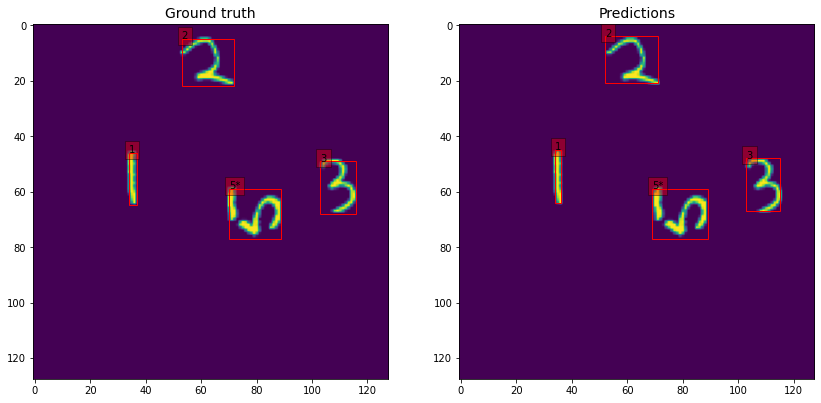

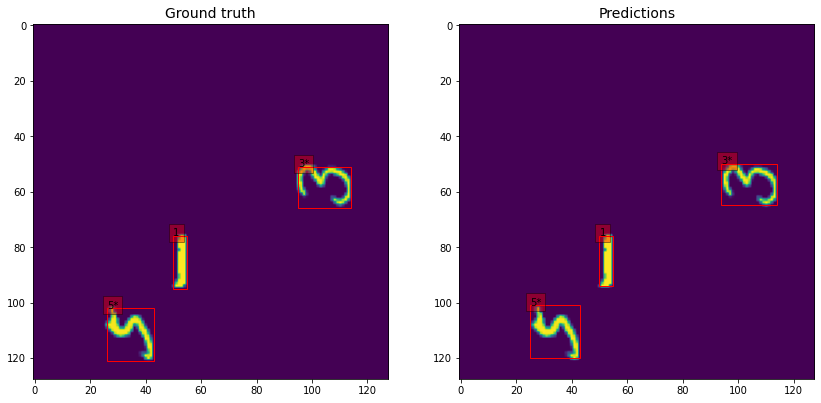

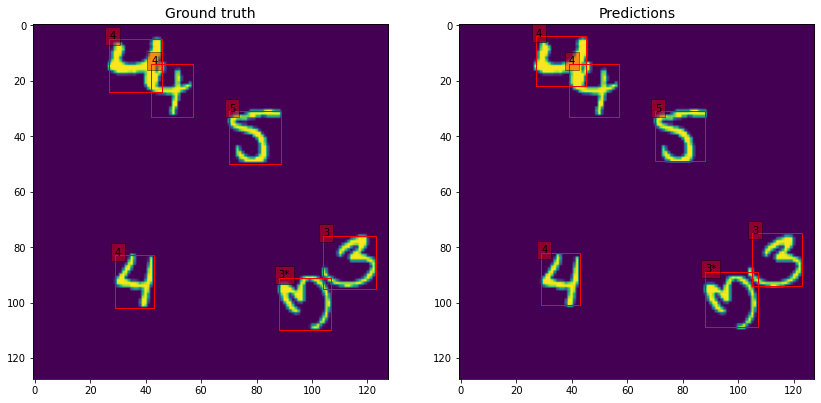

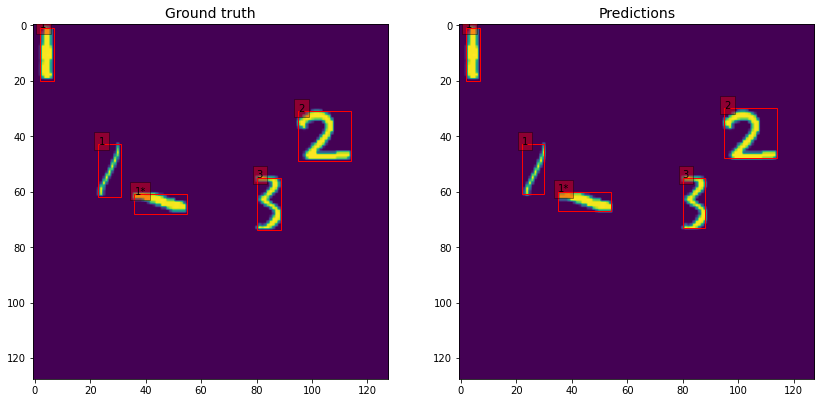

Mismatched predictions


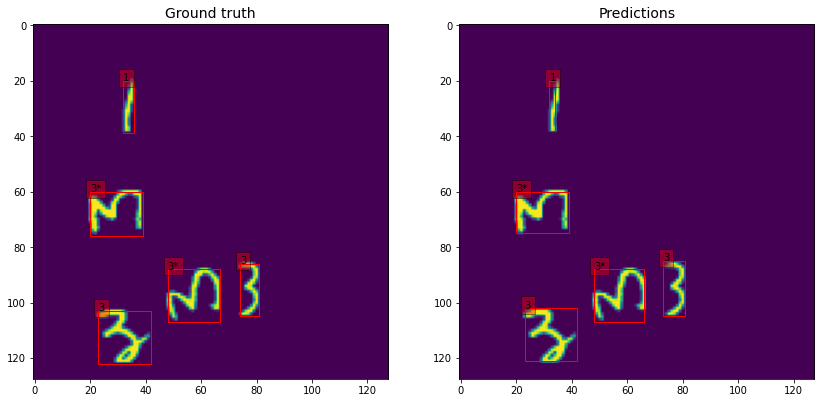

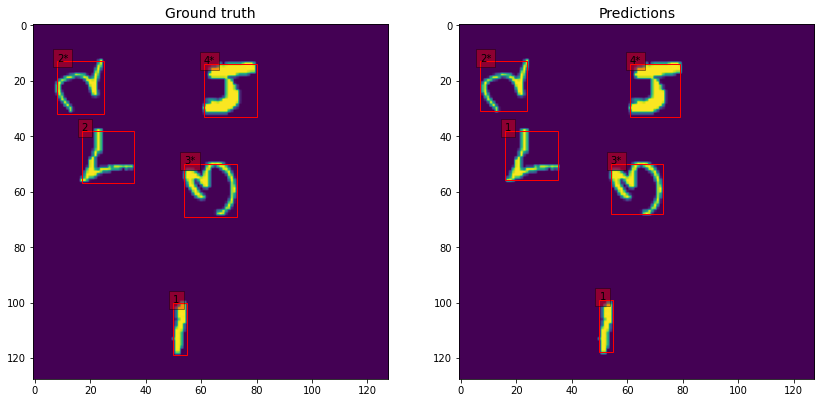

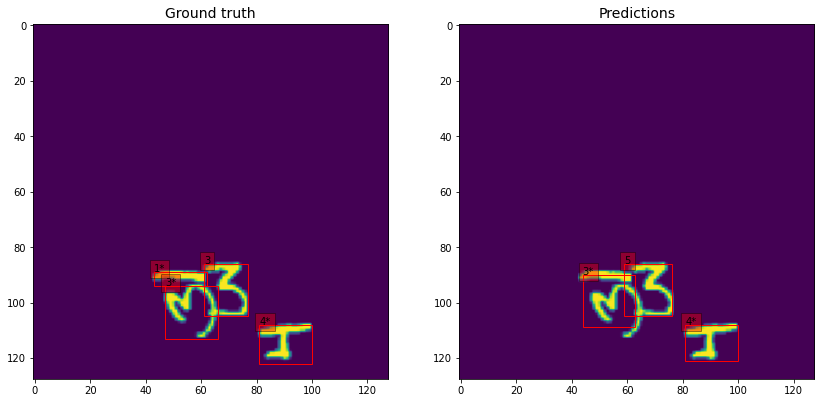

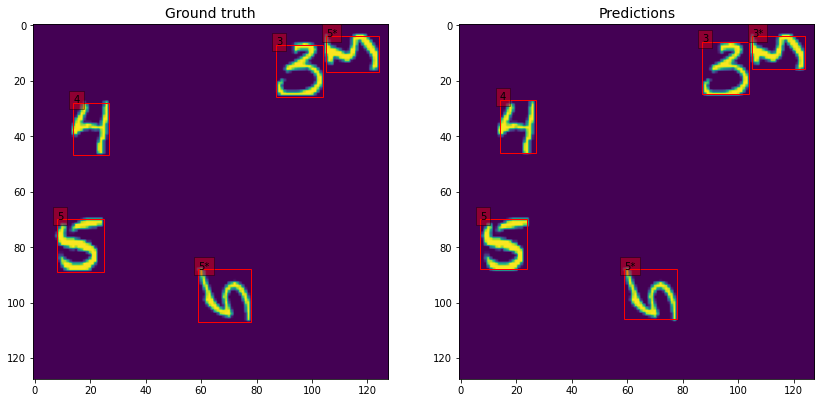

In [109]:
matched_predictions, mismatched_predictions = test(net, TEST_CANVAS)
matched_predictions, mismatched_predictions = matched_predictions[:4], mismatched_predictions[:4]

print('Matched predictions')
for (pred_boxes, canvas) in matched_predictions:
    canvas.plot_comparison(pred_boxes)

print('Mismatched predictions')
for (pred_boxes, canvas) in mismatched_predictions:
    canvas.plot_comparison(pred_boxes)

### Report

1. We may use the same build of the head for both classification and regression.
2. When having a solid backbone, even a few convolutions are enough to extract needed information and achieve accuracy above 20% just after a dozen of minutes.
3. Around 5 anchor sizes seem to be enough to catch most digit compositions. However, there are some hard cases e.g. digits placed very close to each other or very narrow digit 1.
4. Digit 1 in general is the most difficult one to be properly detected. It poses many problems with IOU which may be only resolved using denser anchor grid.
5. One should be very careful when playing with spacial dimensions of a picture because it is easy to place anchors in incorrect grid or confuse picture channels.